In [1]:
import pvdeg
from pvdeg.geospatial import output_template
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import xarray as xr
import dask.array as da
import pickle

from dask.distributed import LocalCluster, Client

In [ ]:
# geospatial scenario with downsample factor 120
tiny_res = xr.open_dataset("tiny-pysam-ground-irradiance.nc", engine='h5netcdf')

tiny_res

In [ ]:
tiny_res

In [ ]:
plt.plot(tiny_res.isel(latitude=0, longitude=2).ground_irradiance)

In [ ]:
pvdeg.geospatial.plot_sparse_analysis(tiny_res, 'annual_poa', 'nearest')

In [2]:
# geospatial scenarion with downsample factor 80
# this fails to capture a lot of information still, it is only 23 points
medium_res = xr.open_dataset("medium-pysam-ground-irradiance.nc", engine='h5netcdf')

medium_res

<xarray.Dataset> Size: 45MB
Dimensions:            (latitude: 4, longitude: 8, time: 17520, distance: 10)
Coordinates:
  * latitude           (latitude) float32 16B 28.13 34.53 40.93 47.33
  * longitude          (longitude) float32 32B -119.1 -112.7 ... -80.74 -74.34
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    ground_irradiance  (time, distance, latitude, longitude) float64 45MB ...
    annual_poa         (latitude, longitude) float64 256B ...

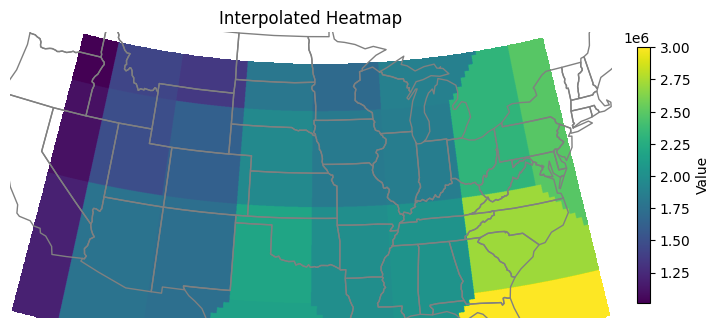

In [3]:
pvdeg.geospatial.plot_sparse_analysis(medium_res, 'annual_poa', 'nearest')

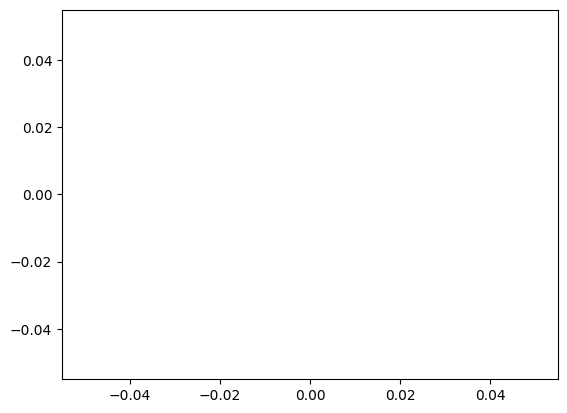

In [4]:
plt.plot(medium_res.isel(latitude=0, longitude=0)["ground_irradiance"])

In [5]:
nonzero_mask = (medium_res["ground_irradiance"] != 0).any(dim="distance")

filtered_data = medium_res["ground_irradiance"].where(nonzero_mask, drop=True)

monthly_avg_ground_irradiance = filtered_data.groupby(filtered_data.time.dt.month).mean()



In [6]:
print(monthly_avg_ground_irradiance)

<xarray.DataArray 'ground_irradiance' (month: 12, distance: 10, latitude: 4,
                                       longitude: 8)> Size: 31kB
array([[[[         nan,          nan,          nan, ...,          nan,
          251.39039332,          nan],
         [ 58.11468011, 135.50811653, 130.04334361, ..., 133.85232808,
          181.60070609,          nan],
         [ 24.4110864 ,  33.46128267,  51.87048449, ...,  90.97590087,
          107.67174537, 131.8752547 ],
         [  8.26424536,  22.79696518,  19.23474817, ...,  24.92301527,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
          103.76320269,          nan],
         [ 55.77057148, 115.69480471, 112.8438219 , ...,  99.32727088,
          120.38113996,          nan],
         [ 22.53734324,  31.22800764,  51.19419846, ...,  86.67066136,
           96.55777299, 120.14957928],
         [  7.38388653,  22.51238988,  18.32837128, ...,  21.68954543,
               

In [7]:
ground_irradiance_4th_index = monthly_avg_ground_irradiance.sel(distance=4)

In [8]:
print(ground_irradiance_4th_index)

<xarray.DataArray 'ground_irradiance' (month: 12, latitude: 4, longitude: 8)> Size: 3kB
array([[[         nan,          nan,          nan,  55.55454222,
                  nan,          nan,  54.30759401,          nan],
        [ 35.66458307,  40.59103488,  40.46357   ,  44.17483044,
          38.23314725,  45.83745845,  47.71876003,          nan],
        [ 39.04732841,  59.41248872,  51.33722895,  45.81060321,
          44.22284708,  47.42881641,  63.82298453,  56.19135839],
        [ 18.42538431,  31.28036718,  32.88908583,  47.30613005,
          47.39860878,  39.10015323,          nan,          nan]],

       [[         nan,          nan,          nan, 104.8980246 ,
                  nan,          nan, 155.29302898,          nan],
        [ 36.79962246,  41.09304574,  45.26533339,  66.73025286,
          49.57519075,  53.01782325,  67.4399442 ,          nan],
        [ 53.60133553,  60.33875813,  55.05855703,  48.44754639,
          58.31600858,  59.08787611,  67.57435107,  54.7163

In [ ]:
ground_irradiance = ground_irradiance_4th_index

mean_irradiance = ground_irradiance.mean(dim="month")

# Create the map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

# Plot data
mesh = ax.pcolormesh(
    mean_irradiance.longitude,
    mean_irradiance.latitude,
    mean_irradiance,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto"
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='blue')
ax.add_feature(cfeature.RIVERS)

# Add colorbar
cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Mean Ground Irradiance")

# Add title
plt.title("Mean Ground Irradiance Across Locations", fontsize=16)

# Show the plot
plt.show()

In [29]:
# unform downsample (40) with 81 points.
medium_res = xr.open_dataset("downsample40-conf01-pysam-ground-irradiance.nc", engine='h5netcdf')

In [30]:
medium_res.nbytes

190759028

In [31]:
monthly_avgs = pvdeg.pysam.ground_irradiance_monthly(medium_res)

In [32]:
monthly_avgs

<xarray.DataArray 'ground_irradiance' (month: 12, distance: 10, latitude: 8,
                                       longitude: 17)> Size: 131kB
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [ 10.41962366,  17.82948461,  11.73724099, ...,  82.28686289,
           77.10985046,          nan],
         [  9.50345957,   9.27590903,  20.44108019, ...,          nan,
           66.06530518,  69.03198783],
         [  7.70186367,   7.26903473,   7.88108233, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [  8.97576756,  12.82691854,  13.06751631, ...,  29.40779764,
           34.2868798 ,          nan],
         [  9.09025682,   8.47786849,  22.07300481, ...,          nan,
           25.07068585,  32.58895902],
         [  2.84022597,   6.25347221,   3.15414737, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [  7.60753284,  10.85365448,  11.06343892, ...,  38.44336481,
           43.25931485,          nan],
         [  7.6539358 ,   7.16639784,  18.66742741, ...,          nan,
           29.44235931,  40.23465042],
         [  2.39546432,   5.25751369,   2.65834079, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * latitude   (latitude) float32 32B 24.85 28.13 31.33 ... 40.93 44.13 47.33
  * longitude  (longitude) float32 68B -122.3 -119.1 -115.9 ... -74.34 -71.14
  * distance   (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 3 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


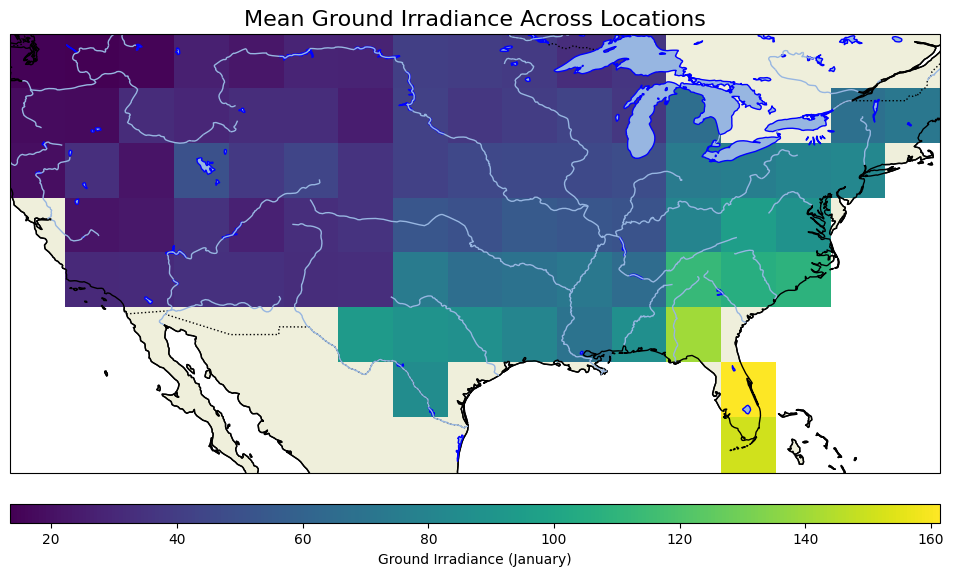

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 4 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


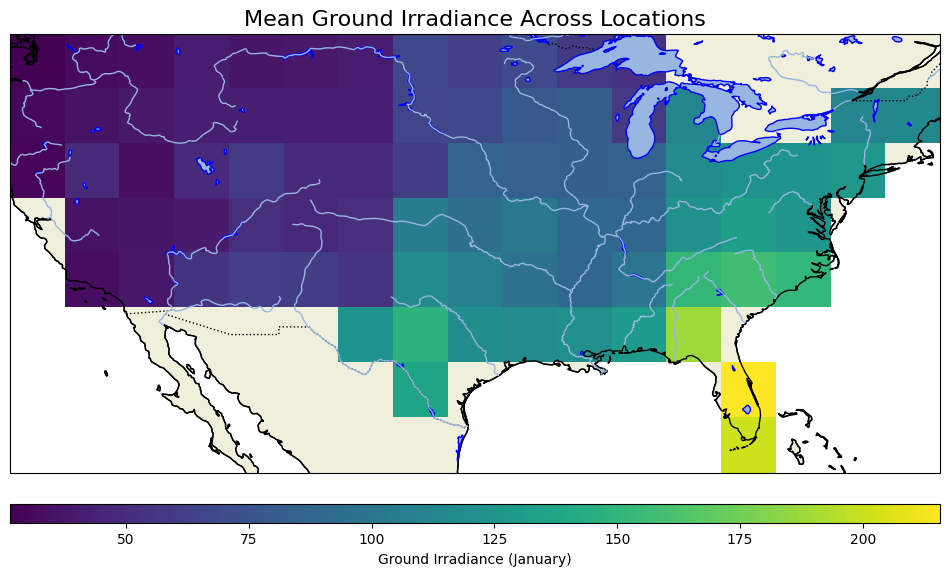

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 5 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


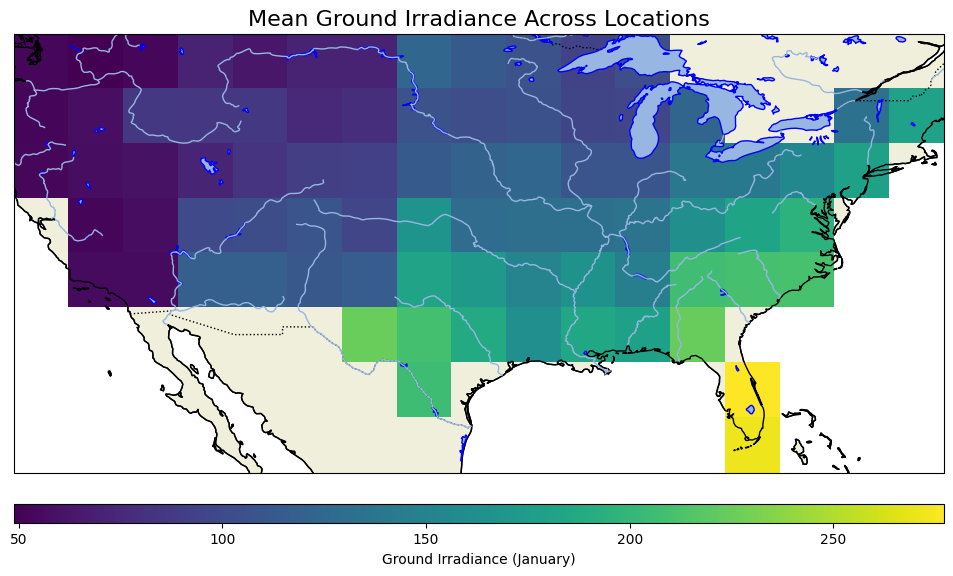

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 6 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


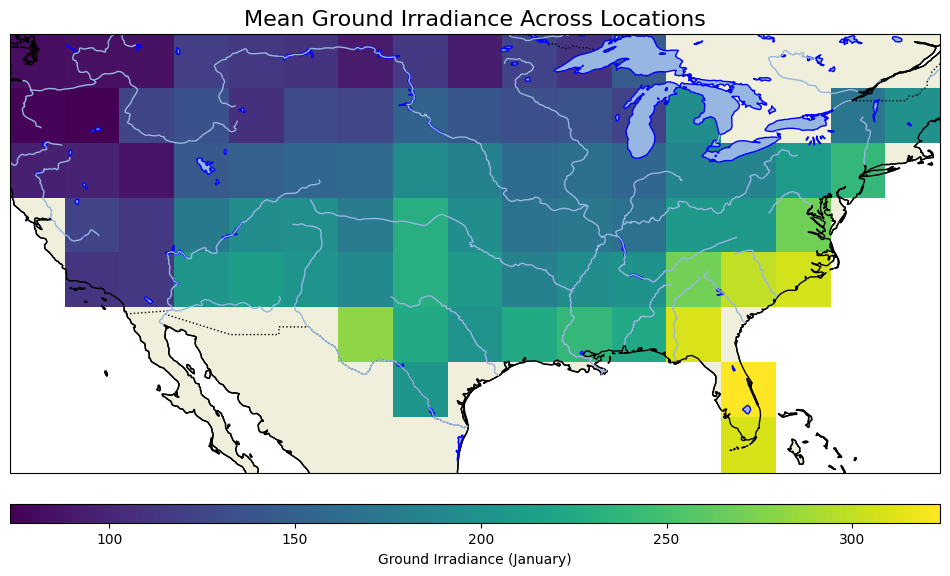

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 7 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


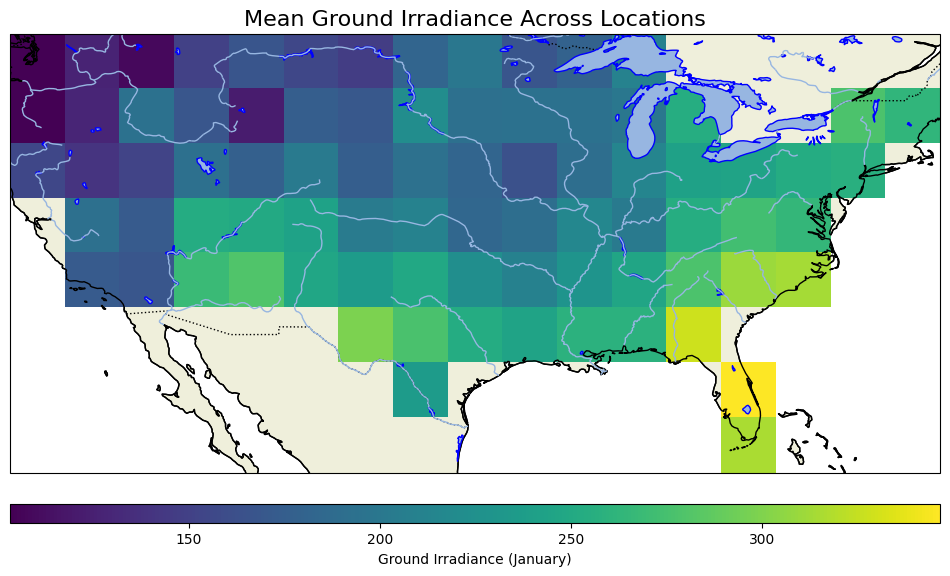

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 8 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


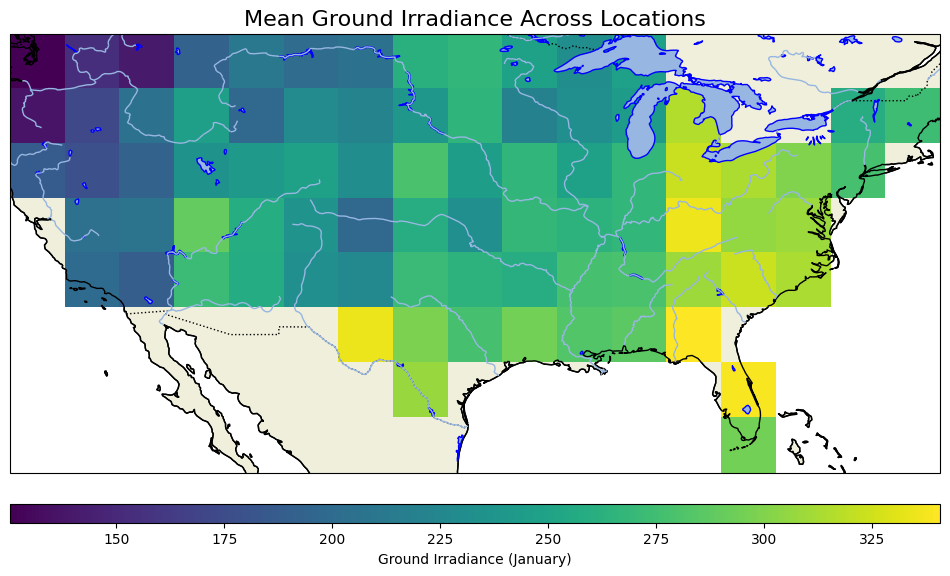

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 9 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


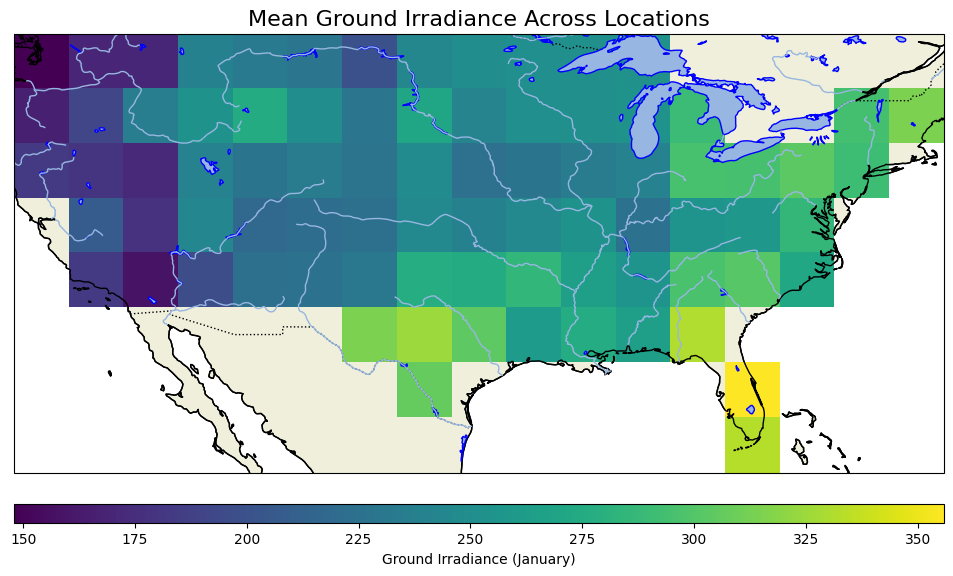

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 10 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


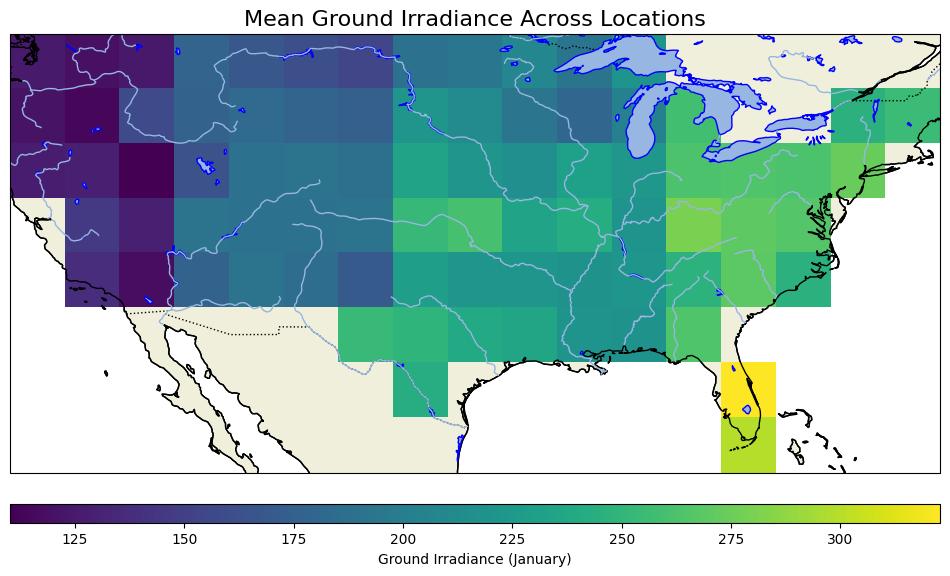

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 11 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


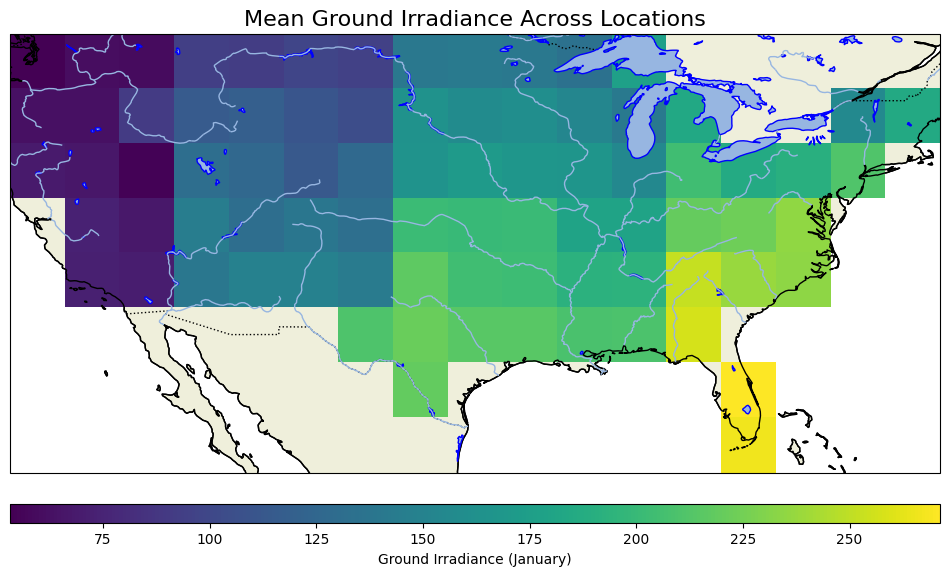

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 12 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


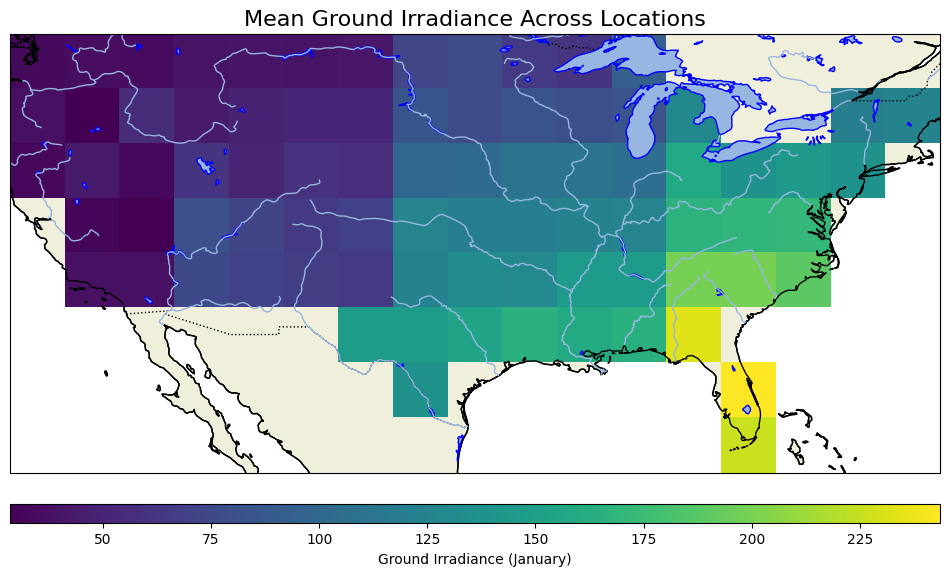

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 13 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


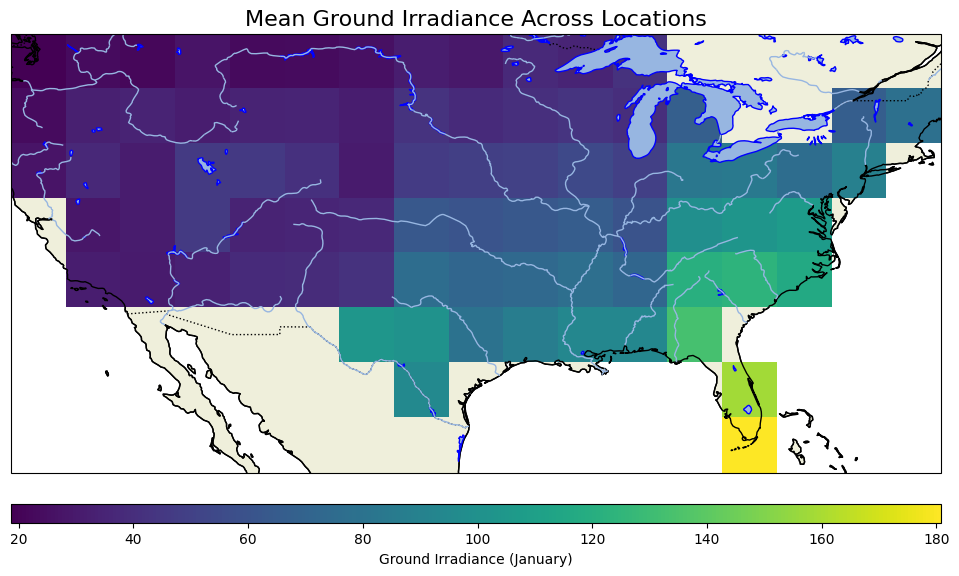

/tmp/ipykernel_3161697/4082187356.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 14 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)


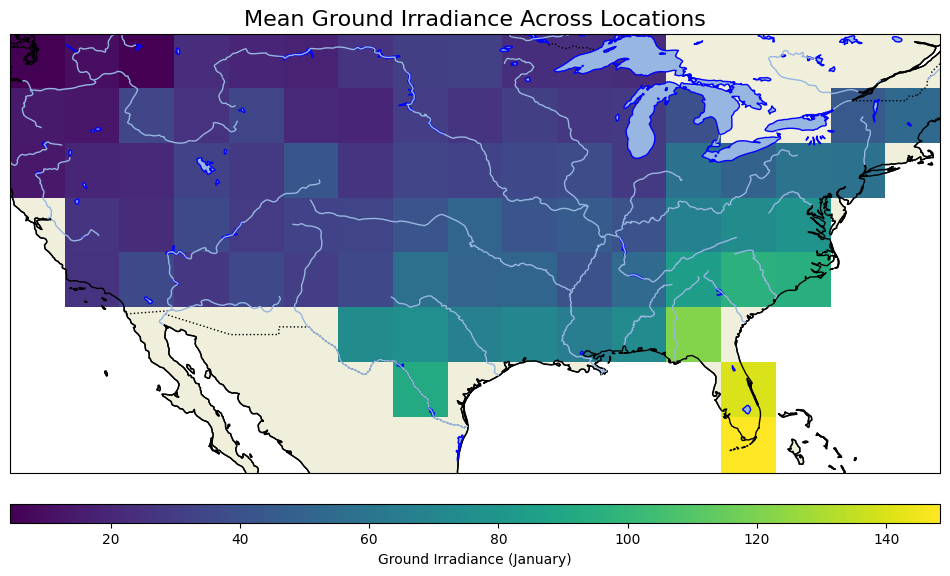

In [ ]:
ground_irradiance = monthly_avgs.sel(distance=4)

# mean_irradiance = ground_irradiance.mean(dim="month")

# # Create the map
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

# Plot data
# mesh = ax.pcolormesh(
#     mean_irradiance.longitude,
#     mean_irradiance.latitude,
#     mean_irradiance,
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     shading="auto"
# )

for i in range(1, 13):

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ground_irradiance.sel(month=i).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),  # Ensure data is plotted in the correct coordinate system
        cmap="viridis",
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.05,
            "aspect": 50,
            "label": "Ground Irradiance (January)"
        }
    )
    
    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='blue')
    ax.add_feature(cfeature.RIVERS)
    
    # Add colorbar
    cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)
    cbar.set_label("Mean Ground Irradiance")
    
    # Add title
    plt.title("Mean Ground Irradiance Across Locations", fontsize=16)
    
    # Show the plot
    plt.show()

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


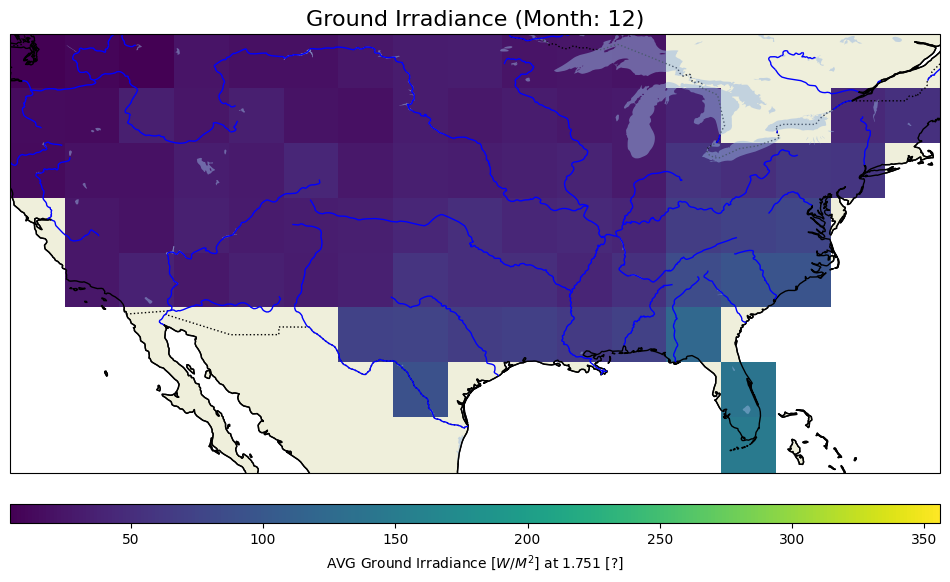

In [36]:
# distances for this sim
distances_conf1 = (
    0.2502810919746036,
     0.7508432759238107,
     1.251405459873018,
     1.751967643822225,
     2.2525298277714323,
     2.753092011720639,
     3.2536541956698466,
     3.7542163796190535,
     4.2547785635682605,
     4.755340747517468
)

# Compute the global min and max values across all months for consistent scaling
vmin = ground_irradiance.min().item()
vmax = ground_irradiance.max().item()

# Set up the figure and axis with Cartopy projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, color='blue')

# Set up the title
title = ax.set_title("", fontsize=16)

# Add an initial dummy plot to create a colorbar
dummy_mesh = ax.pcolormesh(
    ground_irradiance.longitude,
    ground_irradiance.latitude,
    ground_irradiance.isel(month=0),
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)

# Add a colorbar
cbar = plt.colorbar(dummy_mesh, ax=ax, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("AVG Ground Irradiance [$W/M^2$] at 1.751 [?]")

# Remove the dummy mesh
dummy_mesh.remove()

# Initialize the first plot
mesh = None

# Function to update the plot for each frame (month)
def update(month):
    global mesh
    if mesh:
        mesh.remove()  # Remove the previous mesh
    # Select the data for the current month
    month_data = ground_irradiance.sel(month=month)
    # Plot the data
    mesh = ax.pcolormesh(
        month_data.longitude,
        month_data.latitude,
        month_data,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        shading="auto",
        vmin=vmin,  # Fixed minimum value for the color scale
        vmax=vmax   # Fixed maximum value for the color scale
    )
    # Update the title
    title.set_text(f"Ground Irradiance (Month: {month})")
    return mesh, title

# Create the animation
anim = FuncAnimation(
    fig, update, frames=range(1, 13), interval=1000, blit=False
)

# Save the animation as a GIF
anim.save("ground_irradiance_with_colorbar.gif", writer="pillow", fps=1)

# Display the animation (optional)
plt.show()